<a href="https://colab.research.google.com/github/somewhatclueless07/greenwashing_detection/blob/main/greenwashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Greenwashing Detection — Zenodo Green Claims Dataset
# Colab-ready notebook script. This notebook performs:
# 1. dataset download and inspection
# 2. preprocessing
# 3. EDA (word frequencies, wordclouds, class distribution)
# 4. baseline: TF-IDF + Logistic Regression
# 5. transformer: DistilBERT fine-tune (Hugging Face)
# 6. explainability with LIME
# 7. a small Flask app cell to serve predictions (works in Colab with ngrok)


In [1]:
!pip install --quiet datasets transformers[torch] torch torchvision torchaudio scikit-learn lime flask-ngrok wordcloud matplotlib seaborn pandas tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os
import re
import json
import random
import joblib
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from lime.lime_text import LimeTextExplainer

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset


In [3]:
from google.colab import files

In [4]:
# Download the Zenodo Green Claims dataset

# Create data directory
DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Upload manually
print("Please upload green_claims.csv file:")
files.upload()

# Move uploaded file to /content/data
!mv green_claims.csv /content/data/

# Verify upload
out_path = DATA_DIR / "green_claims.csv"
if not out_path.exists():
    print("Dataset not found at /content/data/green_claims.csv. Please upload it again.")
else:
    print("Dataset uploaded successfully to", out_path)



Please upload green_claims.csv file:


Saving green_claims.csv to green_claims.csv
Dataset uploaded successfully to /content/data/green_claims.csv


In [5]:
# 4) Load and inspect dataset

if out_path.exists():
    df = pd.read_csv(out_path)
    print("Dataset loaded. Shape:", df.shape)
    display(df.head(8))
    print("Columns:", df.columns.tolist())
else:
    data = {
        "text": [
            "Our packaging is made from recycled ocean plastic",
            "Now with 100% natural ingredients!",
            "Certified carbon neutral by XYZ cert",
            "We are eco-friendly and sustainable"
        ],
        "label": [0, 0, 1, 0]  # dummy
    }
    df = pd.DataFrame(data)
    print("Using dummy dataset (uploaded file not found).")
    display(df.head())

Dataset loaded. Shape: (773, 7)


,Unnamed: 0,id,tweet,username,domain,label_multi,label_binary
0,0,1298757190677913600,Formulated with Dragon Fruit and Passion Fruit...,arbonne,cosmetics,not_green,not_green
1,1,934482063373283328,Skin Active: how to create an effective skin c...,loreal,cosmetics,explicit_claim,green_claim
2,2,820281365761556480,"Join us tomorrow at #Mumbai #Marathon, for the...",bajajelectrical,electronics,implicit_claim,green_claim
3,3,1136347270109179904,Just CBD. Just argan. Our blend of 100% organi...,josie_maran,cosmetics,explicit_claim,green_claim
4,4,1125037437326168066,Make them do a double take with this #makeup p...,esteelauder,cosmetics,not_green,not_green
5,5,1082768600962863104,"In partnership with @AdaptiveBiotech, we're ex...",microsoft,electronics,not_green,not_green
6,6,1025003243443761153,Experience 24-karat magic with #SupremeSkin ✨ ...,esteelauder,cosmetics,not_green,not_green
7,7,1204534035667656705,"Deep hydration, enchanting fragrance, and real...",herbalessences,cosmetics,implicit_claim,green_claim


Columns: ['Unnamed: 0', 'id', 'tweet', 'username', 'domain', 'label_multi', 'label_binary']


In [6]:
df = df.rename(columns={
    'tweet': 'text',
    'label_binary': 'label'
})

In [7]:
#Basic preprocessing

def clean_text(s):
    if pd.isnull(s):
        return ""
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r"[^a-z0-9\s]", ' ', s)
    s = re.sub(r"\s+", ' ', s).strip()
    return s

print("Cleaning texts...")
df['text_clean'] = df['text'].apply(clean_text)
df = df[['text', 'text_clean', 'label']].dropna().reset_index(drop=True)
print(df.shape)

Cleaning texts...
(773, 3)


In [8]:
#Train/Val/Test split

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print('Train:', train_df.shape, 'Val:', val_df.shape, 'Test:', test_df.shape)

# Save processed
proc_dir = Path('/content/processed')
proc_dir.mkdir(exist_ok=True)
train_df.to_csv(proc_dir / 'train.csv', index=False)
val_df.to_csv(proc_dir / 'val.csv', index=False)
test_df.to_csv(proc_dir / 'test.csv', index=False)

Train: (618, 3) Val: (77, 3) Test: (78, 3)


/tmp/ipython-input-645374842.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Greenwash (0)', 'Genuine (1)'])


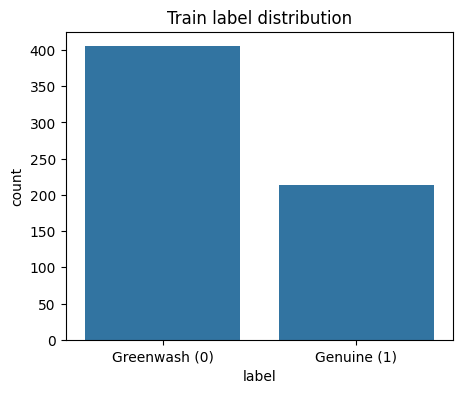

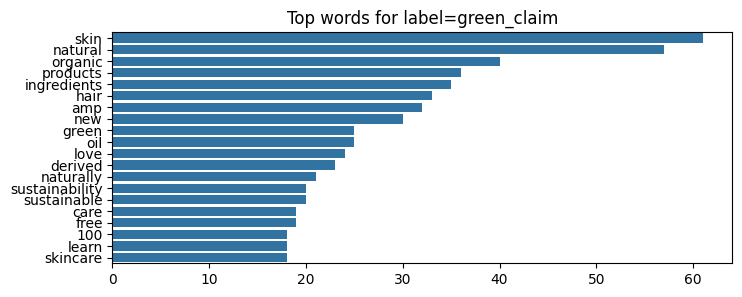

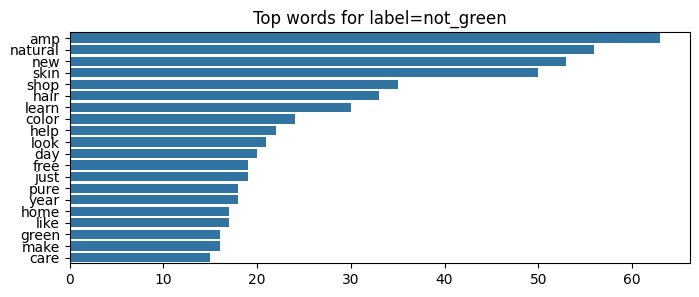

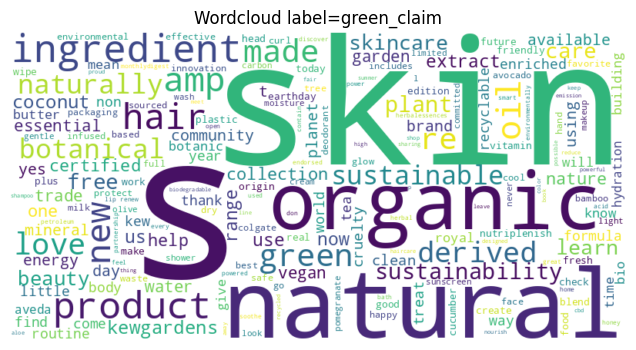

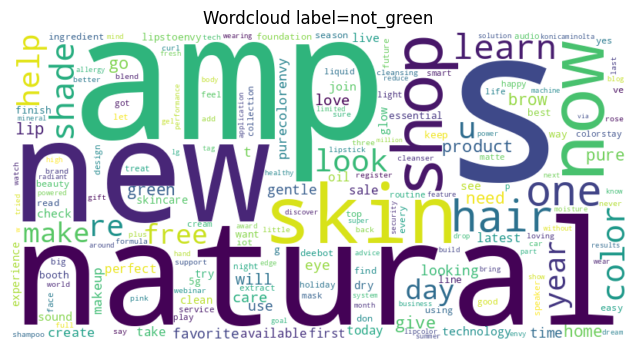

In [9]:
# EDA
plt.figure(figsize=(5,4))
ax = sns.countplot(x='label', data=train_df)
ax.set_xticklabels(['Greenwash (0)', 'Genuine (1)'])
plt.title('Train label distribution')
plt.show()

# top words per class

from sklearn.feature_extraction.text import CountVectorizer

for lbl in sorted(train_df['label'].unique()):
    texts = train_df[train_df['label'] == lbl]['text_clean']
    cv = CountVectorizer(stop_words='english', max_features=50)
    X = cv.fit_transform(texts)
    freqs = list(zip(cv.get_feature_names_out(), X.sum(axis=0).A1))
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:20]
    words, counts = zip(*freqs)
    plt.figure(figsize=(8,3))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top words for label={lbl}')
    plt.show()

# wordclouds
for lbl in sorted(train_df['label'].unique()):
    text_blob = ' '.join(train_df[train_df['label'] == lbl]['text_clean'].tolist())
    wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_blob)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud label={lbl}')
    plt.show()

In [10]:
# Baseline Model: TF-IDF + Logistic Regression

VEC_DIR = Path('/content/models')
VEC_DIR.mkdir(exist_ok=True)

tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words='english')
X_train = tfidf.fit_transform(train_df['text_clean'])
X_val = tfidf.transform(val_df['text_clean'])

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_df['label'])

val_preds = clf.predict(X_val)
print('Validation results (baseline):')
print(classification_report(val_df['label'], val_preds))

# Save models
joblib.dump(tfidf, VEC_DIR / 'tfidf.pkl')
joblib.dump(clf, VEC_DIR / 'logreg.pkl')
print('Saved tfidf and logreg to /content/models')



Validation results (baseline):
              precision    recall  f1-score   support

 green_claim       1.00      0.26      0.41        27
   not_green       0.71      1.00      0.83        50

    accuracy                           0.74        77
   macro avg       0.86      0.63      0.62        77
weighted avg       0.81      0.74      0.69        77

Saved tfidf and logreg to /content/models


Test results (baseline):
              precision    recall  f1-score   support

 green_claim       1.00      0.26      0.41        27
   not_green       0.72      1.00      0.84        51

    accuracy                           0.74        78
   macro avg       0.86      0.63      0.62        78
weighted avg       0.82      0.74      0.69        78



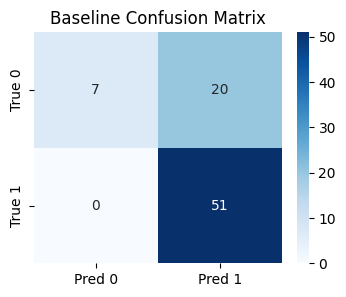

In [11]:
# Evaluate baseline on test set

X_test = tfidf.transform(test_df['text_clean'])
test_preds = clf.predict(X_test)
print('Test results (baseline):')
print(classification_report(test_df['label'], test_preds))

# confusion matrix
cm = confusion_matrix(test_df['label'], test_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('Baseline Confusion Matrix')
plt.show()

In [12]:
!pip install -q --upgrade transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 22.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
